## Set up environment

In [8]:
import sys
sys.path.append('/Users/joy.chen/insitroRepos/posh_internal/common_utils') ## Adding path to common utils
sys.path.append('/Users/joy.chen/insitroRepos/posh_internal/core')


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import json
import boto3

s3 = boto3.resource('s3')

In [10]:
bucket_name = 'insitro-microscopy-nikon-archive'
bucket = s3.Bucket(bucket_name)

In [11]:
import database_utils as db_utils
import image_utils as img_utils

from skimage import exposure,filters,measure,segmentation

In [12]:

from insitro_core.pyxcell.utils import image, data, fluorescence, microscope
from insitro_core.pyxcell.type_definitions import ImageWithNamedChannels
from insitro_core.pyxcell.modules.segmentation import viz
from insitro_core.pyxcell.modules.segmentation.segmenters import cellpose_public
from insitro_core.pyxcell.modules.sequencing import fcn_base_caller, qc
from insitro_core.pyxcell.pipelines import registration

## Get data for PA1234 plate

In [38]:
folder = 'nikon1/pyxscope/PA1234_plate'

allData = pd.DataFrame()
for obj in bucket.objects.filter(Prefix=folder):
    if 'canonical.json' in obj.key:
        print(obj.key)
        file = os.path.join('s3://',bucket_name,obj.key)
        print(f'file : {file}')
        file_obj = s3.Object(bucket_name, obj.key)
        file_content = file_obj.get()['Body'].read().decode('utf-8')
        data = json.loads(file_content)
        df = pd.DataFrame(data['image_list'])
        #['image_metadata_list'])
       # df['measurement_id'] = data['experiment_metadata']['measurement_id']
       # df['plate_barcode'] = data['experiment_metadata']['plate_barcode']
        allData = pd.concat([allData,df])
   #     print(file_content)     
   #     with open(obj) as f:
   #         data = json.load(f)
  #      df = pd.DataFrame(data)

nikon1/pyxscope/PA1234_plate/2023-08-21T18-04-54+00-00_pyxscope_PA1234_1/canonical.json
file : s3://insitro-microscopy-nikon-archive/nikon1/pyxscope/PA1234_plate/2023-08-21T18-04-54+00-00_pyxscope_PA1234_1/canonical.json
nikon1/pyxscope/PA1234_plate/2023-08-21T18-16-31+00-00_pyxscope_PA1234_1/canonical.json
file : s3://insitro-microscopy-nikon-archive/nikon1/pyxscope/PA1234_plate/2023-08-21T18-16-31+00-00_pyxscope_PA1234_1/canonical.json
nikon1/pyxscope/PA1234_plate/2023-08-21T18-18-55+00-00_pyxscope_PA1234_1/canonical.json
file : s3://insitro-microscopy-nikon-archive/nikon1/pyxscope/PA1234_plate/2023-08-21T18-18-55+00-00_pyxscope_PA1234_1/canonical.json
nikon1/pyxscope/PA1234_plate/2023-08-21T18-49-23+00-00_pyxscope_PA1234_1/canonical.json
file : s3://insitro-microscopy-nikon-archive/nikon1/pyxscope/PA1234_plate/2023-08-21T18-49-23+00-00_pyxscope_PA1234_1/canonical.json
nikon1/pyxscope/PA1234_plate/2023-08-21T18-56-33+00-00_pyxscope_PA1234_1/canonical.json
file : s3://insitro-microsco

In [39]:
allData.measurement_id.value_counts()

ff542ed7-987f-4450-a06e-e86dddda6d9d    1923
dfc99045-da86-417b-a3a2-8054bb8b85ca     481
01c8f428-59cb-40bf-9434-88e61c19593f      51
06dd218b-d43c-4aac-a807-ecc944d6c333      18
618c2a33-4e7d-47e5-b577-57f0bead92b4      18
a52259ea-c679-49fe-9e71-e9041481d50b      18
Name: measurement_id, dtype: int64

In [40]:
allData.measurement_id.unique()

array(['06dd218b-d43c-4aac-a807-ecc944d6c333',
       '618c2a33-4e7d-47e5-b577-57f0bead92b4',
       'a52259ea-c679-49fe-9e71-e9041481d50b',
       '01c8f428-59cb-40bf-9434-88e61c19593f',
       'ff542ed7-987f-4450-a06e-e86dddda6d9d',
       'dfc99045-da86-417b-a3a2-8054bb8b85ca'], dtype=object)

In [41]:
allData.columns

Index(['measurement_id', 'field_index', 'plane_index', 'plate_barcode',
       'well_row', 'well_column', 'stage_x_position_um', 'stage_y_position_um',
       'stage_z_position_um', 'stage_x_velocity_x_um_s',
       'stage_y_velocity_y_um_s', 'stage_z_velocity_z_um_s',
       'objective_magnification', 'objective_numerical_aperture',
       'objective_immersion_medium', 'total_magnification',
       'intermediate_magnification', 'physical_pixel_size_x_um',
       'physical_pixel_size_y_um', 'binning_x', 'binning_y',
       'image_size_x_pixels', 'image_size_y_pixels', 'image_bit_depth',
       'detector_label', 'focus_maintainer_enabled',
       'focus_maintainer_offset_um', 'repeat', 'notes', 'channels'],
      dtype='object')

## Select the manual focus data with measurement id.

In [53]:
manual_focus_id = "01c8f428-59cb-40bf-9434-88e61c19593f"
manual_focus_df = allData.loc[allData['measurement_id'] == manual_focus_id]
len(manual_focus_df)

51

In [54]:
manual_focus_df

,measurement_id,field_index,plane_index,plate_barcode,well_row,well_column,stage_x_position_um,stage_y_position_um,stage_z_position_um,stage_x_velocity_x_um_s,...,binning_y,image_size_x_pixels,image_size_y_pixels,image_bit_depth,detector_label,focus_maintainer_enabled,focus_maintainer_offset_um,repeat,notes,channels
0,01c8f428-59cb-40bf-9434-88e61c19593f,0,0,PA1234,1,1,39120.0,-36490.2,3406.60,0.0,...,1.0,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,False,7660.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':..."
1,01c8f428-59cb-40bf-9434-88e61c19593f,1,0,PA1234,1,1,47577.6,-28032.6,3395.00,0.0,...,1.0,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,False,7660.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':..."
2,01c8f428-59cb-40bf-9434-88e61c19593f,2,0,PA1234,1,1,39120.0,-28032.6,3396.70,0.0,...,1.0,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,False,7660.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':..."
3,01c8f428-59cb-40bf-9434-88e61c19593f,3,0,PA1234,1,1,30662.4,-28032.6,3396.74,0.0,...,1.0,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,False,7660.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':..."
4,01c8f428-59cb-40bf-9434-88e61c19593f,4,0,PA1234,1,1,56035.2,-19575.0,3396.64,0.0,...,1.0,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,False,7660.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':..."
5,01c8f428-59cb-40bf-9434-88e61c19593f,5,0,PA1234,1,1,47577.6,-19575.0,3396.68,0.0,...,1.0,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,False,7660.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':..."
6,01c8f428-59cb-40bf-9434-88e61c19593f,6,0,PA1234,1,1,39120.0,-19575.0,3396.74,0.0,...,1.0,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,False,7660.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':..."
7,01c8f428-59cb-40bf-9434-88e61c19593f,7,0,PA1234,1,1,30662.4,-19575.0,3390.78,0.0,...,1.0,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,False,7660.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':..."
8,01c8f428-59cb-40bf-9434-88e61c19593f,8,0,PA1234,1,1,22204.8,-19575.0,3379.20,0.0,...,1.0,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,False,7660.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':..."
9,01c8f428-59cb-40bf-9434-88e61c19593f,9,0,PA1234,1,1,47577.6,-11117.4,3389.40,0.0,...,1.0,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,False,7660.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':..."


In [55]:
manual_focus_df["well_loc"] = manual_focus_df['well_row'].astype(str) +"_"+ manual_focus_df["well_column"].astype(str)


/var/folders/j8/qwstf2vd2jlgn02r_bdl3tc40000gp/T/ipykernel_66177/1994608706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manual_focus_df["well_loc"] = manual_focus_df['well_row'].astype(str) +"_"+ manual_focus_df["well_column"].astype(str)


In [56]:
manual_focus_df['stage_x_position_um'] = manual_focus_df['stage_x_position_um'].div(1000).round(0)
manual_focus_df['stage_y_position_um'] = manual_focus_df['stage_y_position_um'].div(1000).round(0)

/var/folders/j8/qwstf2vd2jlgn02r_bdl3tc40000gp/T/ipykernel_66177/724992918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manual_focus_df['stage_x_position_um'] = manual_focus_df['stage_x_position_um'].div(1000).round(0)
/var/folders/j8/qwstf2vd2jlgn02r_bdl3tc40000gp/T/ipykernel_66177/724992918.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manual_focus_df['stage_y_position_um'] = manual_focus_df['stage_y_position_um'].div(1000).round(0)


In [57]:
manual_focus_df

,measurement_id,field_index,plane_index,plate_barcode,well_row,well_column,stage_x_position_um,stage_y_position_um,stage_z_position_um,stage_x_velocity_x_um_s,...,image_size_x_pixels,image_size_y_pixels,image_bit_depth,detector_label,focus_maintainer_enabled,focus_maintainer_offset_um,repeat,notes,channels,well_loc
0,01c8f428-59cb-40bf-9434-88e61c19593f,0,0,PA1234,1,1,39.0,-36.0,3406.60,0.0,...,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,False,7660.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':...",1_1
1,01c8f428-59cb-40bf-9434-88e61c19593f,1,0,PA1234,1,1,48.0,-28.0,3395.00,0.0,...,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,False,7660.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':...",1_1
2,01c8f428-59cb-40bf-9434-88e61c19593f,2,0,PA1234,1,1,39.0,-28.0,3396.70,0.0,...,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,False,7660.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':...",1_1
3,01c8f428-59cb-40bf-9434-88e61c19593f,3,0,PA1234,1,1,31.0,-28.0,3396.74,0.0,...,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,False,7660.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':...",1_1
4,01c8f428-59cb-40bf-9434-88e61c19593f,4,0,PA1234,1,1,56.0,-20.0,3396.64,0.0,...,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,False,7660.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':...",1_1
5,01c8f428-59cb-40bf-9434-88e61c19593f,5,0,PA1234,1,1,48.0,-20.0,3396.68,0.0,...,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,False,7660.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':...",1_1
6,01c8f428-59cb-40bf-9434-88e61c19593f,6,0,PA1234,1,1,39.0,-20.0,3396.74,0.0,...,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,False,7660.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':...",1_1
7,01c8f428-59cb-40bf-9434-88e61c19593f,7,0,PA1234,1,1,31.0,-20.0,3390.78,0.0,...,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,False,7660.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':...",1_1
8,01c8f428-59cb-40bf-9434-88e61c19593f,8,0,PA1234,1,1,22.0,-20.0,3379.20,0.0,...,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,False,7660.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':...",1_1
9,01c8f428-59cb-40bf-9434-88e61c19593f,9,0,PA1234,1,1,48.0,-11.0,3389.40,0.0,...,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,False,7660.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':...",1_1


In [31]:
#manual_focus_df["x_y_position"] = manual_focus_df['stage_x_position_um'].astype(str) +", "+ manual_focus_df["stage_y_position_um"].astype(str)

/var/folders/j8/qwstf2vd2jlgn02r_bdl3tc40000gp/T/ipykernel_66177/1159688665.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manual_focus_df["x_y_position"] = manual_focus_df['stage_x_position_um'].astype(str) +", "+ manual_focus_df["stage_y_position_um"].astype(str)


In [21]:
manual_focus_df.well_loc.value_counts()

1_1    13
1_3    13
2_3    13
2_1    12
Name: well_loc, dtype: int64

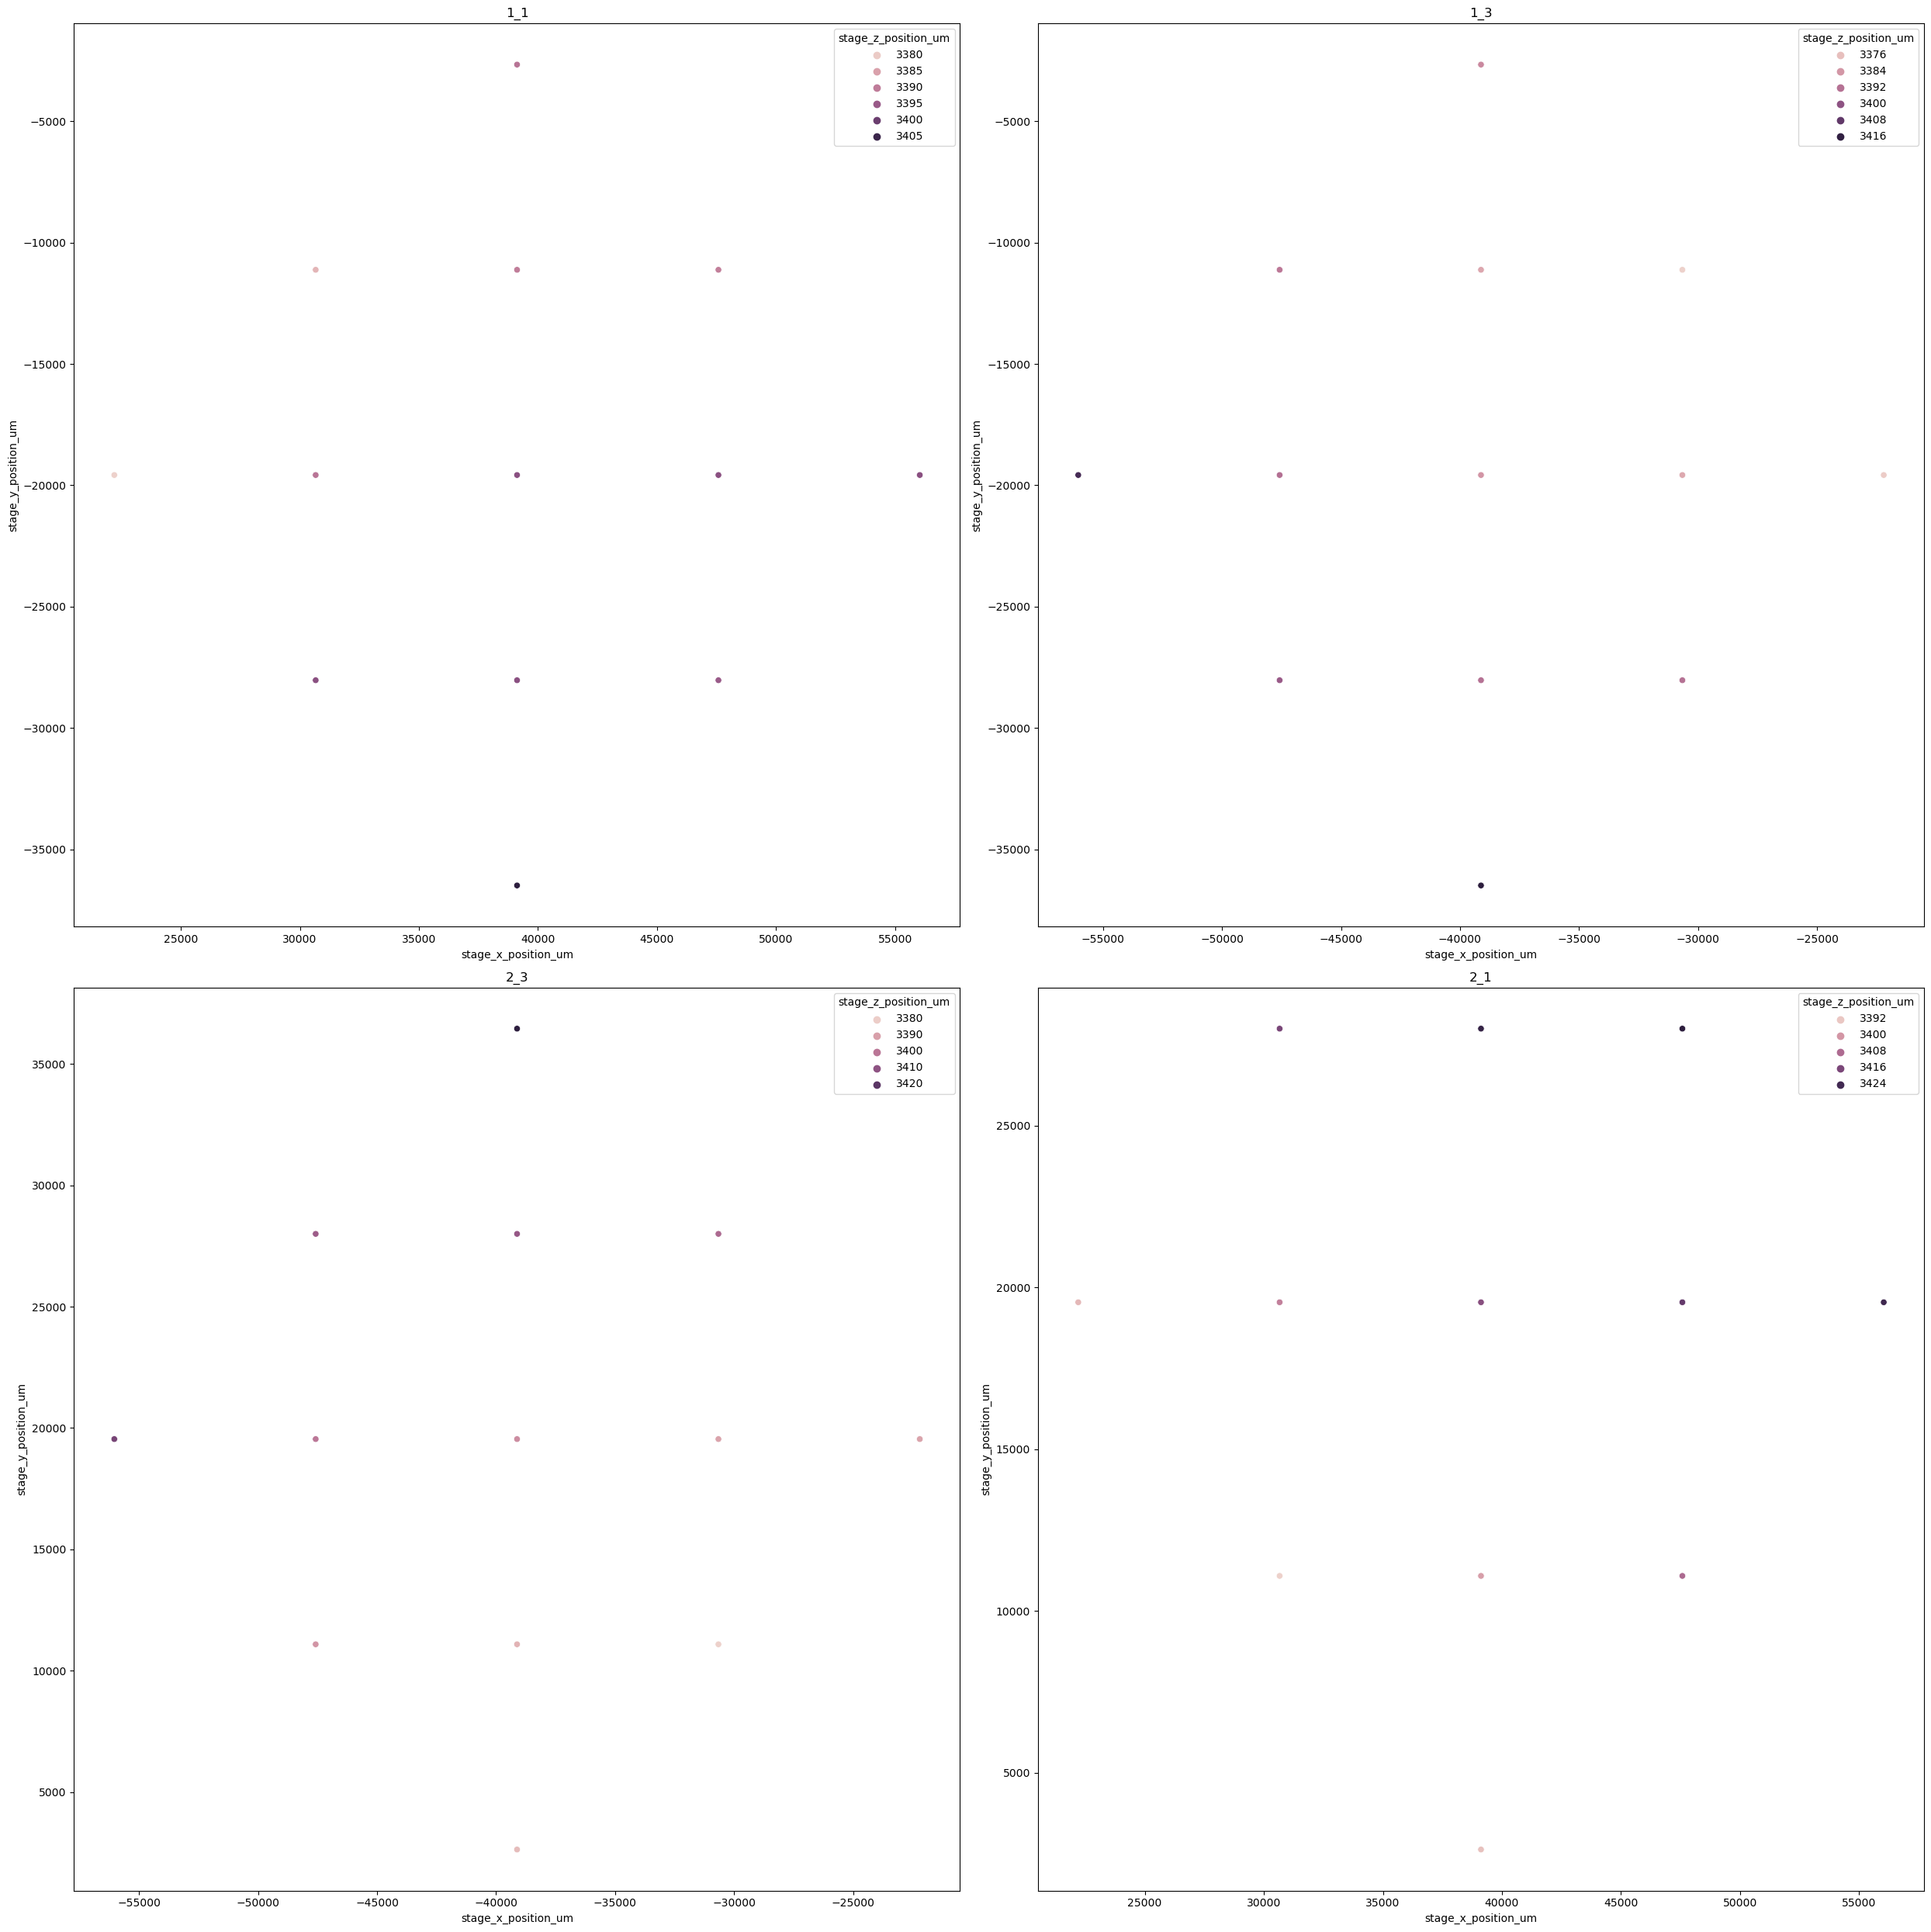

In [22]:
well_locs = manual_focus_df['well_loc'].unique()
cols = 2
rows = len(well_locs)//cols
fig,ax = plt.subplots(ncols = cols, nrows = rows, figsize=(25,25))
for i, well_loc in enumerate(well_locs):
    row = i//cols
    col = i%cols
    features_subset = manual_focus_df[manual_focus_df['well_loc'] == well_loc]
    sns.scatterplot(x = 'stage_x_position_um', y = 'stage_y_position_um', data = features_subset, hue = 'stage_z_position_um', ax = ax[row][col]),
    ax[row][col].set_title(well_loc)   
plt.tight_layout()

In [37]:
manual_focus_df.x_y_position.to_list()

['39120.0, -36490.2',
 '47577.6, -28032.6',
 '39120.0, -28032.6',
 '30662.4, -28032.6',
 '56035.2, -19575.0',
 '47577.6, -19575.0',
 '39120.0, -19575.0',
 '30662.4, -19575.0',
 '22204.8, -19575.0',
 '47577.6, -11117.4',
 '39120.0, -11117.4',
 '30662.4, -11117.4',
 '39120.0, -2659.8',
 '-39120.0, -36490.2',
 '-30662.4, -28032.6',
 '-39120.0, -28032.6',
 '-47577.6, -28032.6',
 '-22204.8, -19575.0',
 '-30662.4, -19575.0',
 '-39120.0, -19575.0',
 '-47577.6, -19575.0',
 '-56035.2, -19575.0',
 '-30662.4, -11117.4',
 '-39120.0, -11117.4',
 '-47577.6, -11117.4',
 '-39120.0, -2659.8',
 '-39120.0, 2629.8',
 '-30662.4, 11087.4',
 '-39120.0, 11087.4',
 '-47577.6, 11087.4',
 '-22204.8, 19545.0',
 '-30662.4, 19545.0',
 '-39120.0, 19545.0',
 '-47577.6, 19545.0',
 '-56035.2, 19545.0',
 '-30662.4, 28002.6',
 '-39120.0, 28002.6',
 '-47577.6, 28002.6',
 '-39120.0, 36460.2',
 '39120.0, 2629.8',
 '47577.6, 11087.4',
 '39120.0, 11087.4',
 '30662.4, 11087.4',
 '56035.2, 19545.0',
 '47577.6, 19545.0',
 '39120

In [32]:
PFS_focus_df["x_y_position"] = PFS_focus_df['stage_x_position_um'].astype(str) +", "+ PFS_focus_df["stage_y_position_um"].astype(str)

/var/folders/j8/qwstf2vd2jlgn02r_bdl3tc40000gp/T/ipykernel_66177/1914600310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PFS_focus_df["x_y_position"] = PFS_focus_df['stage_x_position_um'].astype(str) +", "+ PFS_focus_df["stage_y_position_um"].astype(str)


In [36]:
PFS_focus_df.x_y_position.to_list()

['41965.44, -36647.64',
 '40542.72, -36647.64',
 '39120.0, -36647.64',
 '37697.28, -36647.64',
 '36274.56, -36647.64',
 '46233.6, -35224.92',
 '44810.88, -35224.92',
 '43388.16, -35224.92',
 '41965.44, -35224.92',
 '40542.72, -35224.92',
 '39120.0, -35224.92',
 '37697.28, -35224.92',
 '36274.56, -35224.92',
 '34851.84, -35224.92',
 '33429.12, -35224.92',
 '32006.4, -35224.92',
 '49079.04, -33802.2',
 '47656.32, -33802.2',
 '46233.6, -33802.2',
 '44810.88, -33802.2',
 '43388.16, -33802.2',
 '41965.44, -33802.2',
 '40542.72, -33802.2',
 '39120.0, -33802.2',
 '37697.28, -33802.2',
 '36274.56, -33802.2',
 '34851.84, -33802.2',
 '33429.12, -33802.2',
 '32006.4, -33802.2',
 '30583.68, -33802.2',
 '29160.96, -33802.2',
 '50501.76, -32379.48',
 '49079.04, -32379.48',
 '47656.32, -32379.48',
 '46233.6, -32379.48',
 '44810.88, -32379.48',
 '43388.16, -32379.48',
 '41965.44, -32379.48',
 '40542.72, -32379.48',
 '39120.0, -32379.48',
 '37697.28, -32379.48',
 '36274.56, -32379.48',
 '34851.84, -323

## Get data for PFS group

In [58]:
PFS_focus_id = "ff542ed7-987f-4450-a06e-e86dddda6d9d"
PFS_focus_df = allData.loc[allData['measurement_id'] == PFS_focus_id]
len(PFS_focus_df)

1923

In [59]:
PFS_focus_df["well_loc"] = PFS_focus_df['well_row'].astype(str) +"_"+ PFS_focus_df["well_column"].astype(str)

/var/folders/j8/qwstf2vd2jlgn02r_bdl3tc40000gp/T/ipykernel_66177/1169092789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PFS_focus_df["well_loc"] = PFS_focus_df['well_row'].astype(str) +"_"+ PFS_focus_df["well_column"].astype(str)


In [60]:
PFS_focus_df['stage_x_position_um'] = PFS_focus_df['stage_x_position_um'].div(1000).round(0)
PFS_focus_df['stage_y_position_um'] = PFS_focus_df['stage_y_position_um'].div(1000).round(0)

/var/folders/j8/qwstf2vd2jlgn02r_bdl3tc40000gp/T/ipykernel_66177/74756439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PFS_focus_df['stage_x_position_um'] = PFS_focus_df['stage_x_position_um'].div(1000).round(0)
/var/folders/j8/qwstf2vd2jlgn02r_bdl3tc40000gp/T/ipykernel_66177/74756439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PFS_focus_df['stage_y_position_um'] = PFS_focus_df['stage_y_position_um'].div(1000).round(0)


In [61]:
PFS_focus_df

,measurement_id,field_index,plane_index,plate_barcode,well_row,well_column,stage_x_position_um,stage_y_position_um,stage_z_position_um,stage_x_velocity_x_um_s,...,image_size_x_pixels,image_size_y_pixels,image_bit_depth,detector_label,focus_maintainer_enabled,focus_maintainer_offset_um,repeat,notes,channels,well_loc
0,ff542ed7-987f-4450-a06e-e86dddda6d9d,0,0,PA1234,1,1,42.0,-37.0,3403.64,0.0,...,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,True,7699.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':...",1_1
1,ff542ed7-987f-4450-a06e-e86dddda6d9d,1,0,PA1234,1,1,41.0,-37.0,3403.48,0.0,...,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,True,7699.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':...",1_1
2,ff542ed7-987f-4450-a06e-e86dddda6d9d,2,0,PA1234,1,1,39.0,-37.0,3404.46,0.0,...,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,True,7699.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':...",1_1
3,ff542ed7-987f-4450-a06e-e86dddda6d9d,3,0,PA1234,1,1,38.0,-37.0,3406.40,0.0,...,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,True,7699.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':...",1_1
4,ff542ed7-987f-4450-a06e-e86dddda6d9d,4,0,PA1234,1,1,36.0,-37.0,3406.52,0.0,...,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,True,7699.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':...",1_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918,ff542ed7-987f-4450-a06e-e86dddda6d9d,475,0,PA1234,2,1,32.0,35.0,3439.04,0.0,...,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,True,7717.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':...",2_1
1919,ff542ed7-987f-4450-a06e-e86dddda6d9d,476,0,PA1234,2,1,42.0,37.0,3442.36,0.0,...,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,True,7717.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':...",2_1
1920,ff542ed7-987f-4450-a06e-e86dddda6d9d,477,0,PA1234,2,1,41.0,37.0,3442.40,0.0,...,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,True,7717.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':...",2_1
1921,ff542ed7-987f-4450-a06e-e86dddda6d9d,478,0,PA1234,2,1,39.0,37.0,3442.80,0.0,...,2304.0,2304.0,16.0,Detector:Hamamatsu_FusionBT_C14440:0x000407D5,True,7717.0,None,None,"[{'name': 'channel_0', 'measurement_datetime':...",2_1


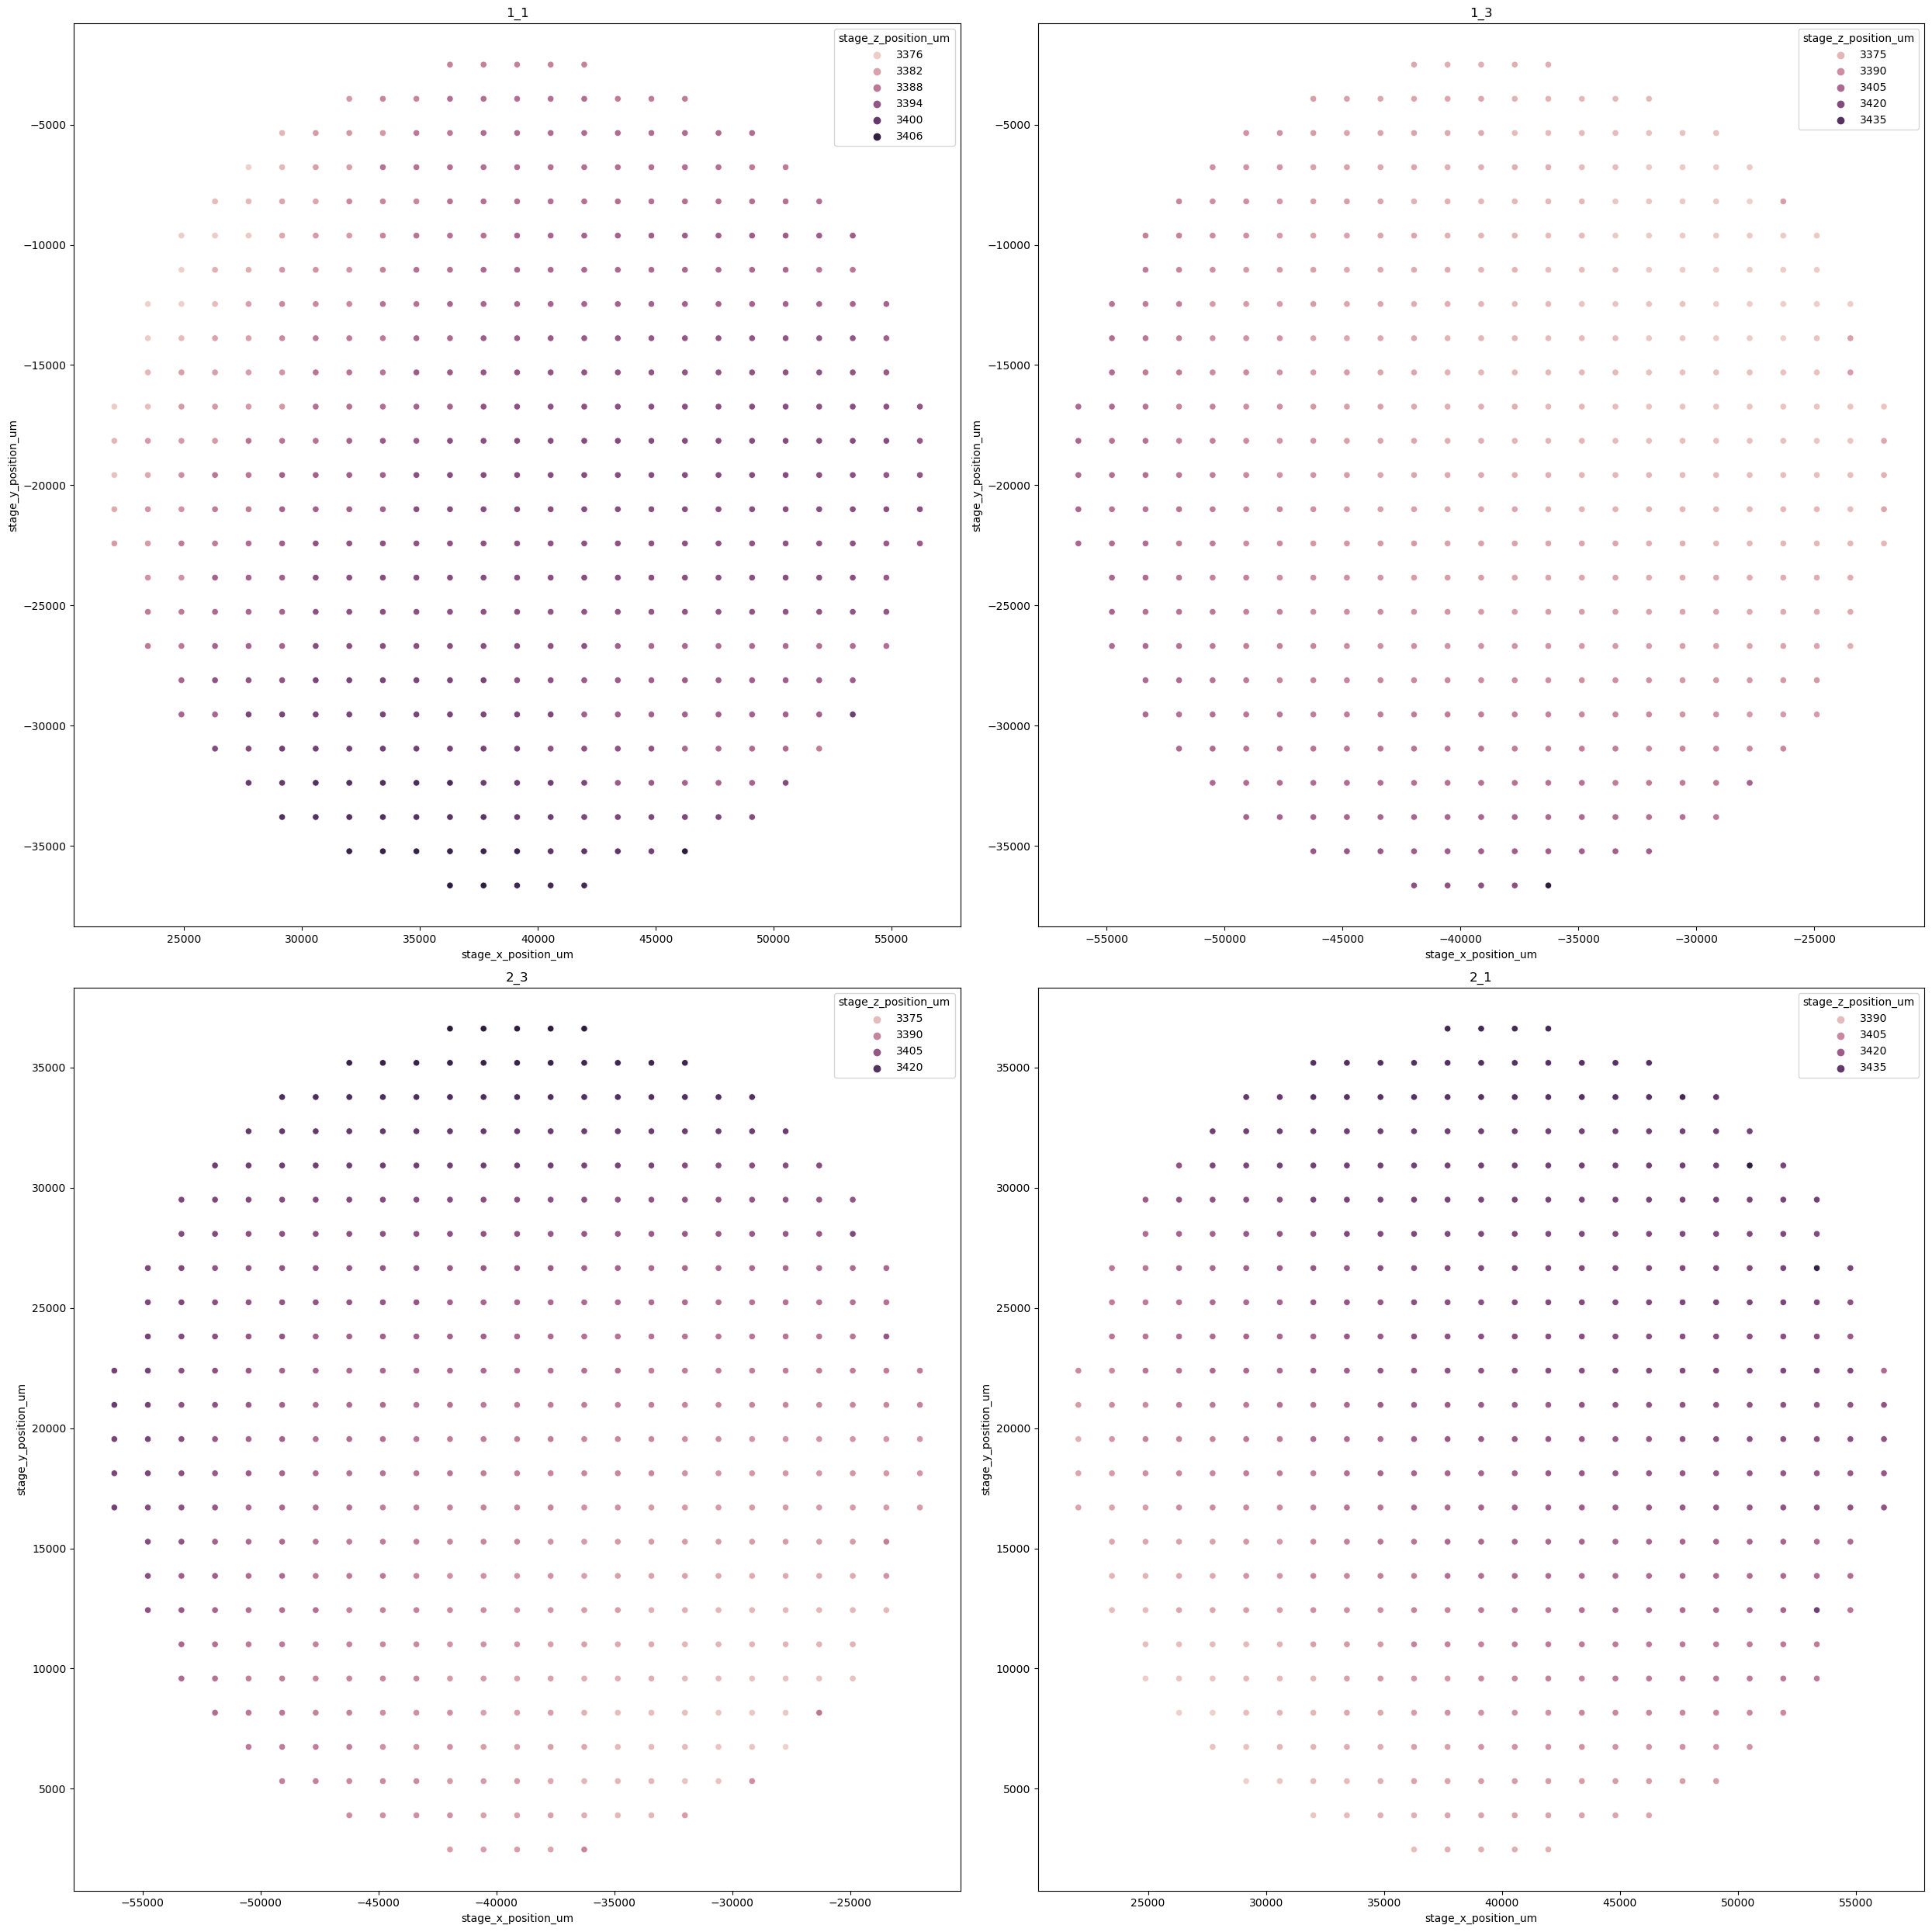

In [34]:
well_locs = PFS_focus_df['well_loc'].unique()
cols = 2
rows = len(well_locs)//cols 
fig,ax = plt.subplots(ncols = cols, nrows = rows, figsize=(25,25))
for i, well_loc in enumerate(well_locs):
    row = i//cols
    col = i%cols
    features_subset = PFS_focus_df[PFS_focus_df['well_loc'] == well_loc]
    sns.scatterplot(x = 'stage_x_position_um', y = 'stage_y_position_um', data = features_subset, hue = 'stage_z_position_um', ax = ax[row][col]),
    ax[row][col].set_title(well_loc)   
plt.tight_layout()

In [91]:
manual_focus_df["stage_x_position_um"] = manual_focus_df["stage_x_position_um"].astype('int64')
manual_focus_df["stage_y_position_um"] = manual_focus_df["stage_y_position_um"].astype('int64')
#manual_focus_df[['stage_x_position_um', 'stage_y_position_um']] = df[['stage_x_position_um', 'stage_y_position_um']].apply(pd.to_numeric)
PFS_focus_df['stage_x_position_um'] = PFS_focus_df['stage_x_position_um'].astype('int64')
PFS_focus_df['stage_y_position_um'] = PFS_focus_df['stage_y_position_um'].astype('int64')


/var/folders/j8/qwstf2vd2jlgn02r_bdl3tc40000gp/T/ipykernel_21223/671674153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manual_focus_df["stage_x_position_um"] = manual_focus_df["stage_x_position_um"].astype('int64')
/var/folders/j8/qwstf2vd2jlgn02r_bdl3tc40000gp/T/ipykernel_21223/671674153.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manual_focus_df["stage_y_position_um"] = manual_focus_df["stage_y_position_um"].astype('int64')
/var/folders/j8/qwstf2vd2jlgn02r_bdl3tc40000gp/T/ipykernel_21223/6

In [62]:
combined_df = pd.merge(manual_focus_df, PFS_focus_df,  how='inner', on=['stage_x_position_um','stage_y_position_um'])

In [64]:
combined_df.columns

Index(['measurement_id_x', 'field_index_x', 'plane_index_x', 'plate_barcode_x',
       'well_row_x', 'well_column_x', 'stage_x_position_um',
       'stage_y_position_um', 'stage_z_position_um_x',
       'stage_x_velocity_x_um_s_x', 'stage_y_velocity_y_um_s_x',
       'stage_z_velocity_z_um_s_x', 'objective_magnification_x',
       'objective_numerical_aperture_x', 'objective_immersion_medium_x',
       'total_magnification_x', 'intermediate_magnification_x',
       'physical_pixel_size_x_um_x', 'physical_pixel_size_y_um_x',
       'binning_x_x', 'binning_y_x', 'image_size_x_pixels_x',
       'image_size_y_pixels_x', 'image_bit_depth_x', 'detector_label_x',
       'focus_maintainer_enabled_x', 'focus_maintainer_offset_um_x',
       'repeat_x', 'notes_x', 'channels_x', 'well_loc_x', 'measurement_id_y',
       'field_index_y', 'plane_index_y', 'plate_barcode_y', 'well_row_y',
       'well_column_y', 'stage_z_position_um_y', 'stage_x_velocity_x_um_s_y',
       'stage_y_velocity_y_um_s_y', 

In [71]:
comparison_df = combined_df[["stage_x_position_um","stage_y_position_um","stage_z_position_um_x","stage_z_position_um_y"]]
comparison_df.rename(
    columns={"stage_x_position_um": "x_mm", "stage_y_position_um": "y_mm", "stage_z_position_um_x": "z_um_manaul", "stage_z_position_um_y": "z_um_PFS"},
    inplace= True
)
comparison_df["differece_manual_pfs"] = comparison_df["z_um_manaul"] - comparison_df["z_um_PFS"]
comparison_df

/var/folders/j8/qwstf2vd2jlgn02r_bdl3tc40000gp/T/ipykernel_66177/2079950952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df.rename(
/var/folders/j8/qwstf2vd2jlgn02r_bdl3tc40000gp/T/ipykernel_66177/2079950952.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df["differece_manual_pfs"] = comparison_df["z_um_manaul"] - comparison_df["z_um_PFS"]


,x_mm,y_mm,z_um_manaul,z_um_PFS,differece_manual_pfs
0,48.0,-28.0,3395.00,3392.50,2.50
1,39.0,-28.0,3396.70,3394.78,1.92
2,31.0,-28.0,3396.74,3397.24,-0.50
3,56.0,-20.0,3396.64,3394.28,2.36
4,48.0,-20.0,3396.68,3395.60,1.08
5,39.0,-20.0,3396.74,3395.62,1.12
6,31.0,-20.0,3390.78,3391.84,-1.06
7,22.0,-20.0,3379.20,3377.40,1.80
8,48.0,-11.0,3389.40,3390.66,-1.26
9,39.0,-11.0,3389.76,3390.72,-0.96


In [73]:
difference = comparison_df[["differece_manual_pfs"]]
difference.describe()

,differece_manual_pfs
count,46.000000
mean,1.064348
std,3.815703
min,-7.820000
25%,-1.035000
50%,1.610000
75%,3.480000
max,9.500000


In [92]:
manual_focus_df.dtypes

measurement_id                   object
field_index                       int64
plane_index                       int64
plate_barcode                    object
well_row                          int64
well_column                       int64
stage_x_position_um               int64
stage_y_position_um               int64
stage_z_position_um             float64
stage_x_velocity_x_um_s         float64
stage_y_velocity_y_um_s         float64
stage_z_velocity_z_um_s         float64
objective_magnification         float64
objective_numerical_aperture    float64
objective_immersion_medium       object
total_magnification             float64
intermediate_magnification      float64
physical_pixel_size_x_um        float64
physical_pixel_size_y_um        float64
binning_x                       float64
binning_y                       float64
image_size_x_pixels             float64
image_size_y_pixels             float64
image_bit_depth                 float64
detector_label                   object


In [37]:
combined_df.columns

Index(['measurement_id_x', 'field_index_x', 'plane_index_x', 'plate_barcode_x',
       'well_row_x', 'well_column_x', 'stage_x_position_um',
       'stage_y_position_um', 'stage_z_position_um_x',
       'stage_x_velocity_x_um_s_x', 'stage_y_velocity_y_um_s_x',
       'stage_z_velocity_z_um_s_x', 'objective_magnification_x',
       'objective_numerical_aperture_x', 'objective_immersion_medium_x',
       'total_magnification_x', 'intermediate_magnification_x',
       'physical_pixel_size_x_um_x', 'physical_pixel_size_y_um_x',
       'binning_x_x', 'binning_y_x', 'image_size_x_pixels_x',
       'image_size_y_pixels_x', 'image_bit_depth_x', 'detector_label_x',
       'focus_maintainer_enabled_x', 'focus_maintainer_offset_um_x',
       'repeat_x', 'notes_x', 'channels_x', 'well_loc_x', 'measurement_id_y',
       'field_index_y', 'plane_index_y', 'plate_barcode_y', 'well_row_y',
       'well_column_y', 'stage_z_position_um_y', 'stage_x_velocity_x_um_s_y',
       'stage_y_velocity_y_um_s_y', 

In [94]:
## combine two df from test and validation.
comparison = combined_df[["measurement_id_x","measurement_id_y","stage_x_position_um","stage_y_position_um","stage_z_position_um_x","stage_z_position_um_y"]]
comparison

,measurement_id_x,measurement_id_y,stage_x_position_um,stage_y_position_um,stage_z_position_um_x,stage_z_position_um_y
0,01c8f428-59cb-40bf-9434-88e61c19593f,ff542ed7-987f-4450-a06e-e86dddda6d9d,39120,-19575,3396.74,3395.62
1,01c8f428-59cb-40bf-9434-88e61c19593f,ff542ed7-987f-4450-a06e-e86dddda6d9d,-39120,-19575,3384.46,3380.24
2,01c8f428-59cb-40bf-9434-88e61c19593f,ff542ed7-987f-4450-a06e-e86dddda6d9d,-39120,19545,3394.52,3392.10
3,01c8f428-59cb-40bf-9434-88e61c19593f,ff542ed7-987f-4450-a06e-e86dddda6d9d,39120,19545,3414.18,3421.40


In [68]:
manual_focus_df.dtypes

measurement_id                   object
field_index                       int64
plane_index                       int64
plate_barcode                    object
well_row                          int64
well_column                       int64
stage_x_position_um             float64
stage_y_position_um             float64
stage_z_position_um             float64
stage_x_velocity_x_um_s         float64
stage_y_velocity_y_um_s         float64
stage_z_velocity_z_um_s         float64
objective_magnification         float64
objective_numerical_aperture    float64
objective_immersion_medium       object
total_magnification             float64
intermediate_magnification      float64
physical_pixel_size_x_um        float64
physical_pixel_size_y_um        float64
binning_x                       float64
binning_y                       float64
image_size_x_pixels             float64
image_size_y_pixels             float64
image_bit_depth                 float64
detector_label                   object


In [5]:
plate_dir = "s3://insitro-microscopy-nikon-archive/nikon1/pyxscope/PA1234_plate"

In [13]:
plate_id = 'PA1234'
microscope_id = 'nikon1_pyxscope'

#acqusition dataframe for ISS
list_of_measurementsDF = data.get_canonical_acquisitions(plate_id)
list_of_measurementsDF

2023-08-22 11:56:53,520 [INFO] Found credentials in shared credentials file: ~/.aws/credentials


,microscope_label,plate_barcode,measurement_id,measurement_datetime,total_images,channels
0,charmander_pyxscope,PA1234,adc711ce-9aa8-4132-b173-157c0b71baa5,2023-06-22 22:20:11.387835,342,"[posh_a, posh_c, posh_g, posh_nucleus, posh_t]"
1,charmander_pyxscope,PA1234,97d31943-9852-4bf9-99e9-f853a7d804a1,2023-06-22 22:42:18.118471,30,"[posh_a, posh_c, posh_g, posh_nucleus, posh_t]"
2,charmander_pyxscope,PA1234,1fd4d407-321d-4f5a-b484-4649df60cf0b,2023-06-22 22:47:00.591188,30,"[posh_a, posh_c, posh_g, posh_nucleus, posh_t]"
3,nikon4_pyxscope,PA1234,01e86ac0-2ee5-4ed3-aae2-ac94a0d7c5b1,2023-08-16 23:20:24.984799,6,"[DPC Bottom, DPC Left, DPC Right, DPC Top]"
4,nikon4_pyxscope,PA1234,455f922c-490e-4ac2-a849-3b6052bde03f,2023-08-16 23:21:46.237074,5,[Brightfield]
5,nikon4_pyxscope,PA1234,12615c06-4f86-4c31-8e3d-bbcf81598302,2023-08-16 23:23:01.465038,6,"[DPC Bottom, DPC Left, DPC Right, DPC Top]"
6,nikon4_pyxscope,PA1234,b38447b0-2312-4cb3-ae79-82ee2d86af8f,2023-08-16 23:24:27.808007,6,"[DAPI, DPC Bottom, DPC Left, DPC Right, DPC Top]"
7,nikon4_pyxscope,PA1234,41f90906-38c8-49c8-8719-cfdf0ecab3dd,2023-08-16 23:25:45.155005,6,"[DPC Bottom, DPC Left, DPC Right, DPC Top, GFP]"
8,nikon4_pyxscope,PA1234,e4315ef3-6506-4e21-9248-fbf3eac23983,2023-08-16 23:27:01.395893,6,"[DPC Bottom, DPC Left, DPC Right, DPC Top, mAp..."
9,nikon4_pyxscope,PA1234,65866ace-9503-4d11-95b2-f38f6cc72e84,2023-08-16 23:35:01.260289,5,[GFP]


In [9]:
Manual_focus = list_of_measurementsDF.loc[list_of_measurementsDF["measurement_id"] == "eda37d49-4891-482d-94d5-741a02c0e48c"]

In [11]:
Manual_focus_measurement = Manual_focus['measurement_id'].values
MF_acquisition_df = data.create_multi_acquisition_canonical_dataframe(Manual_focus_measurement)
MF_acquisition_df

,id,microscope_id,measurement_id,file_path,raw_image_file_paths,time_index,plane_index,field_index,plate_barcode,well_row,...,measurement_datetime,observation_datetime,created_at_1,last_updated_at_1,exposure_time_milliseconds,index,channel_index,source_metadata_file_path,quadralateral_shearing_interferometry_modality_settings_id,well_loc
0,17383429,4,eda37d49-4891-482d-94d5-741a02c0e48c,s3://insitro-microscopy-data/prod/canonical/9e...,[s3://insitro-microscopy-nikon-archive/nikon1/...,0,0,0,PA16732,1,...,2023-08-03 19:59:20.881566,2023-08-03 19:59:20.881566,2023-08-03 20:06:58.030086,None,50.0035,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
1,17383430,4,eda37d49-4891-482d-94d5-741a02c0e48c,s3://insitro-microscopy-data/prod/canonical/ab...,[s3://insitro-microscopy-nikon-archive/nikon1/...,1,0,1,PA16732,1,...,2023-08-03 19:59:21.824566,2023-08-03 19:59:21.824566,2023-08-03 20:06:58.030089,None,50.0035,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
2,17383431,4,eda37d49-4891-482d-94d5-741a02c0e48c,s3://insitro-microscopy-data/prod/canonical/f9...,[s3://insitro-microscopy-nikon-archive/nikon1/...,2,0,2,PA16732,1,...,2023-08-03 19:59:22.751566,2023-08-03 19:59:22.751566,2023-08-03 20:06:58.030092,None,50.0035,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
3,17383432,4,eda37d49-4891-482d-94d5-741a02c0e48c,s3://insitro-microscopy-data/prod/canonical/53...,[s3://insitro-microscopy-nikon-archive/nikon1/...,3,0,3,PA16732,1,...,2023-08-03 19:59:23.630566,2023-08-03 19:59:23.630566,2023-08-03 20:06:58.030093,None,50.0035,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
4,17383433,4,eda37d49-4891-482d-94d5-741a02c0e48c,s3://insitro-microscopy-data/prod/canonical/f4...,[s3://insitro-microscopy-nikon-archive/nikon1/...,4,0,4,PA16732,1,...,2023-08-03 19:59:25.054566,2023-08-03 19:59:25.054566,2023-08-03 20:06:58.030095,None,50.0035,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
5,17383434,4,eda37d49-4891-482d-94d5-741a02c0e48c,s3://insitro-microscopy-data/prod/canonical/28...,[s3://insitro-microscopy-nikon-archive/nikon1/...,5,0,5,PA16732,1,...,2023-08-03 19:59:25.853566,2023-08-03 19:59:25.853566,2023-08-03 20:06:58.030096,None,50.0035,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
6,17383435,4,eda37d49-4891-482d-94d5-741a02c0e48c,s3://insitro-microscopy-data/prod/canonical/bc...,[s3://insitro-microscopy-nikon-archive/nikon1/...,6,0,6,PA16732,1,...,2023-08-03 19:59:26.764566,2023-08-03 19:59:26.764566,2023-08-03 20:06:58.030098,None,50.0035,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
7,17383436,4,eda37d49-4891-482d-94d5-741a02c0e48c,s3://insitro-microscopy-data/prod/canonical/d6...,[s3://insitro-microscopy-nikon-archive/nikon1/...,7,0,7,PA16732,1,...,2023-08-03 19:59:27.628566,2023-08-03 19:59:27.628566,2023-08-03 20:06:58.030099,None,50.0035,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
8,17383437,4,eda37d49-4891-482d-94d5-741a02c0e48c,s3://insitro-microscopy-data/prod/canonical/ff...,[s3://insitro-microscopy-nikon-archive/nikon1/...,8,0,8,PA16732,1,...,2023-08-03 19:59:28.603566,2023-08-03 19:59:28.603566,2023-08-03 20:06:58.030101,None,50.0035,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
9,17383438,4,eda37d49-4891-482d-94d5-741a02c0e48c,s3://insitro-microscopy-data/prod/canonical/0b...,[s3://insitro-microscopy-nikon-archive/nikon1/...,9,0,9,PA16732,1,...,2023-08-03 19:59:30.186566,2023-08-03 19:59:30.186566,2023-08-03 20:06:58.030102,None,50.0035,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01


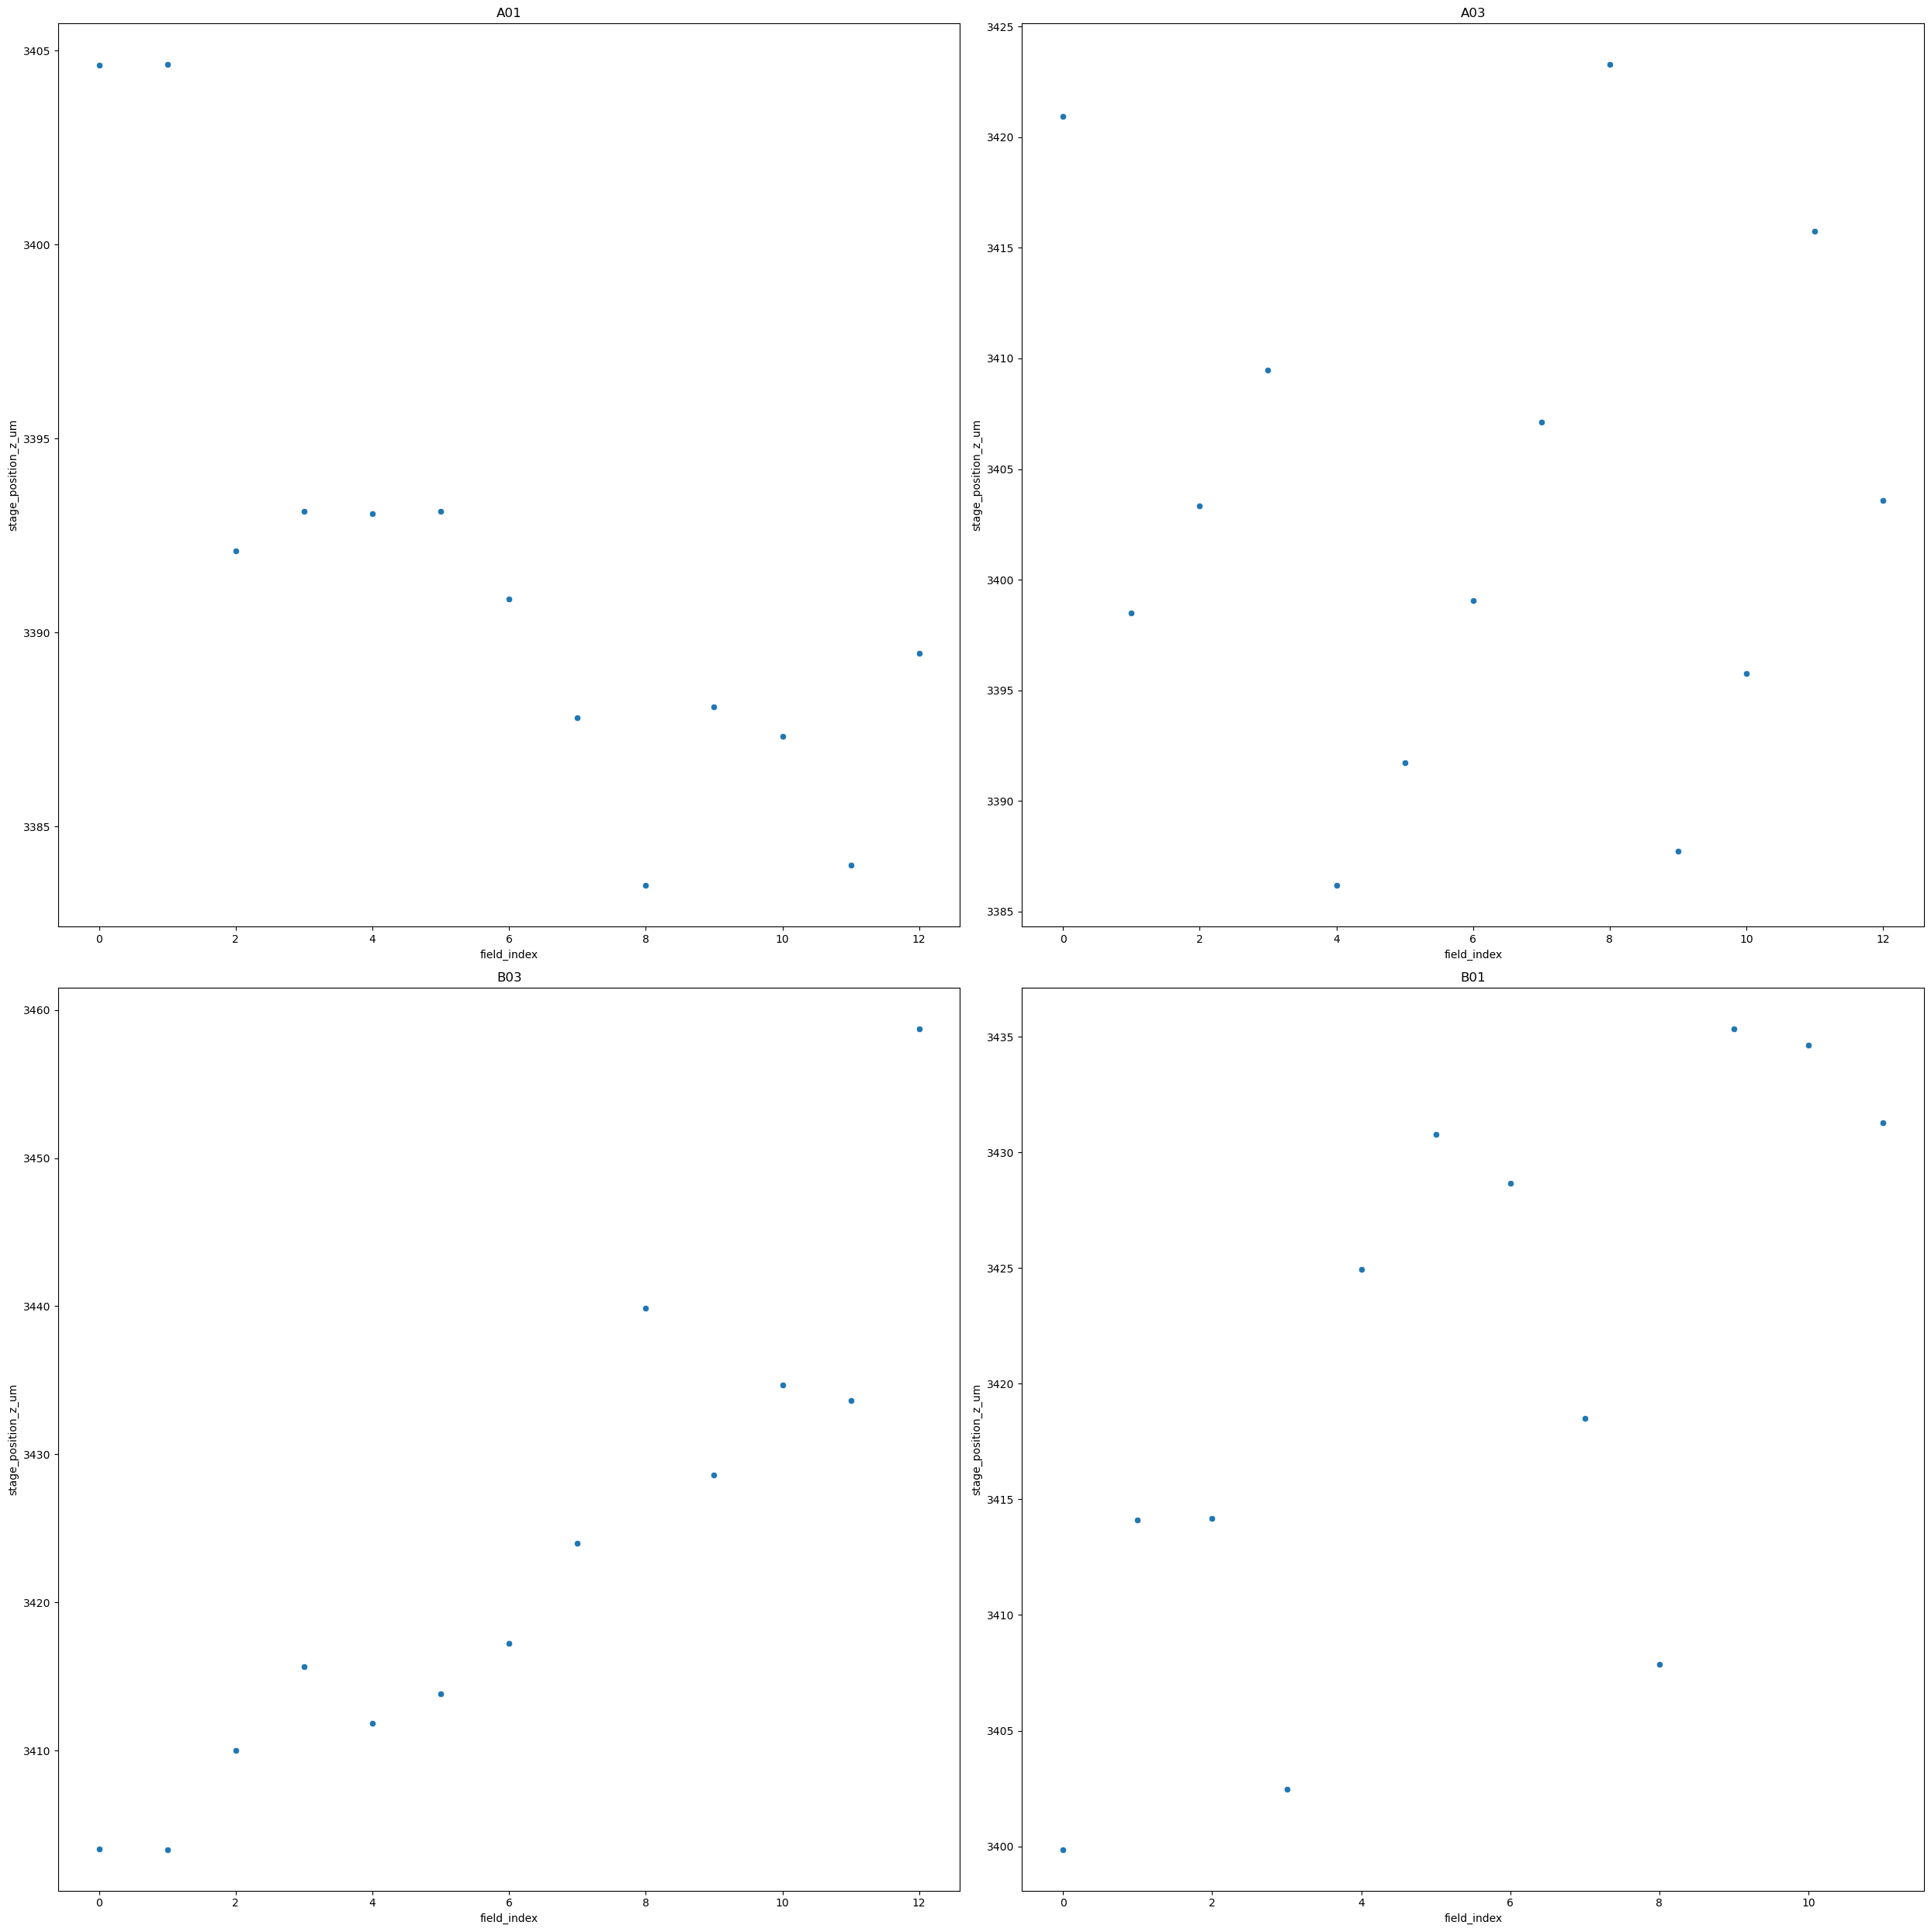

In [22]:
well_locs = MF_acquisition_df['well_loc'].unique()
cols = 2
rows = len(well_locs)//cols
fig,ax = plt.subplots(ncols = cols, nrows = rows, figsize=(25,25))
for i, well_loc in enumerate(well_locs):
    row = i//cols
    col = i%cols
    features_subset = MF_acquisition_df[MF_acquisition_df['well_loc'] == well_loc]
    sns.scatterplot(x = "field_index", y = "stage_position_z_um", data = features_subset, ax = ax[row][col]),
    ax[row][col].set_title(well_loc)   
plt.tight_layout()

In [10]:
PFS_focus = list_of_measurementsDF.loc[list_of_measurementsDF["measurement_id"] == "00050a00-1788-448f-a04e-ac1580fb6fee"]

In [19]:
PFS_focus_measurement = PFS_focus['measurement_id'].values
PFS_acquisition_df = data.create_multi_acquisition_canonical_dataframe(PFS_focus_measurement)
PFS_acquisition_df.columns

Index(['id', 'microscope_id', 'measurement_id', 'file_path',
       'raw_image_file_paths', 'time_index', 'plane_index', 'field_index',
       'plate_barcode', 'well_row', 'well_column', 'stage_position_x_um',
       'stage_position_y_um', 'stage_position_z_um',
       'stage_velocity_x_um_per_s', 'stage_velocity_y_um_per_s',
       'stage_velocity_z_um_per_s', 'created_at', 'last_updated_at',
       'pixel_size_x_um', 'pixel_size_y_um', 'image_size_x_pixels',
       'image_size_y_pixels', 'image_bit_depth', 'binning_x', 'binning_y',
       'objective_magnification', 'objective_numerical_aperture',
       'objective_immersion_medium', 'intermediate_magnification',
       'total_magnification', 'focus_maintainer_enabled',
       'focus_maintainer_offset_um', 'repeat', 'discard', 'notes', 'id_1',
       'image_id', 'widefield_fluorescence_settings_id',
       'spinning_disk_confocal_fluorescence_settings_id',
       'lamp_kohler_diascopic_settings_id',
       'unconstrained_angular_sourc

In [18]:
updated = PFS_acquisition_df[["field_index","stage_position_z_um"]]
updated

,field_index,stage_position_z_um
0,0,3375.0
1,1,3375.0
2,2,3375.0
3,3,3375.0
4,4,3375.0
...,...,...
1919,476,3375.0
1920,477,3375.0
1921,478,3375.0
1922,479,3375.0


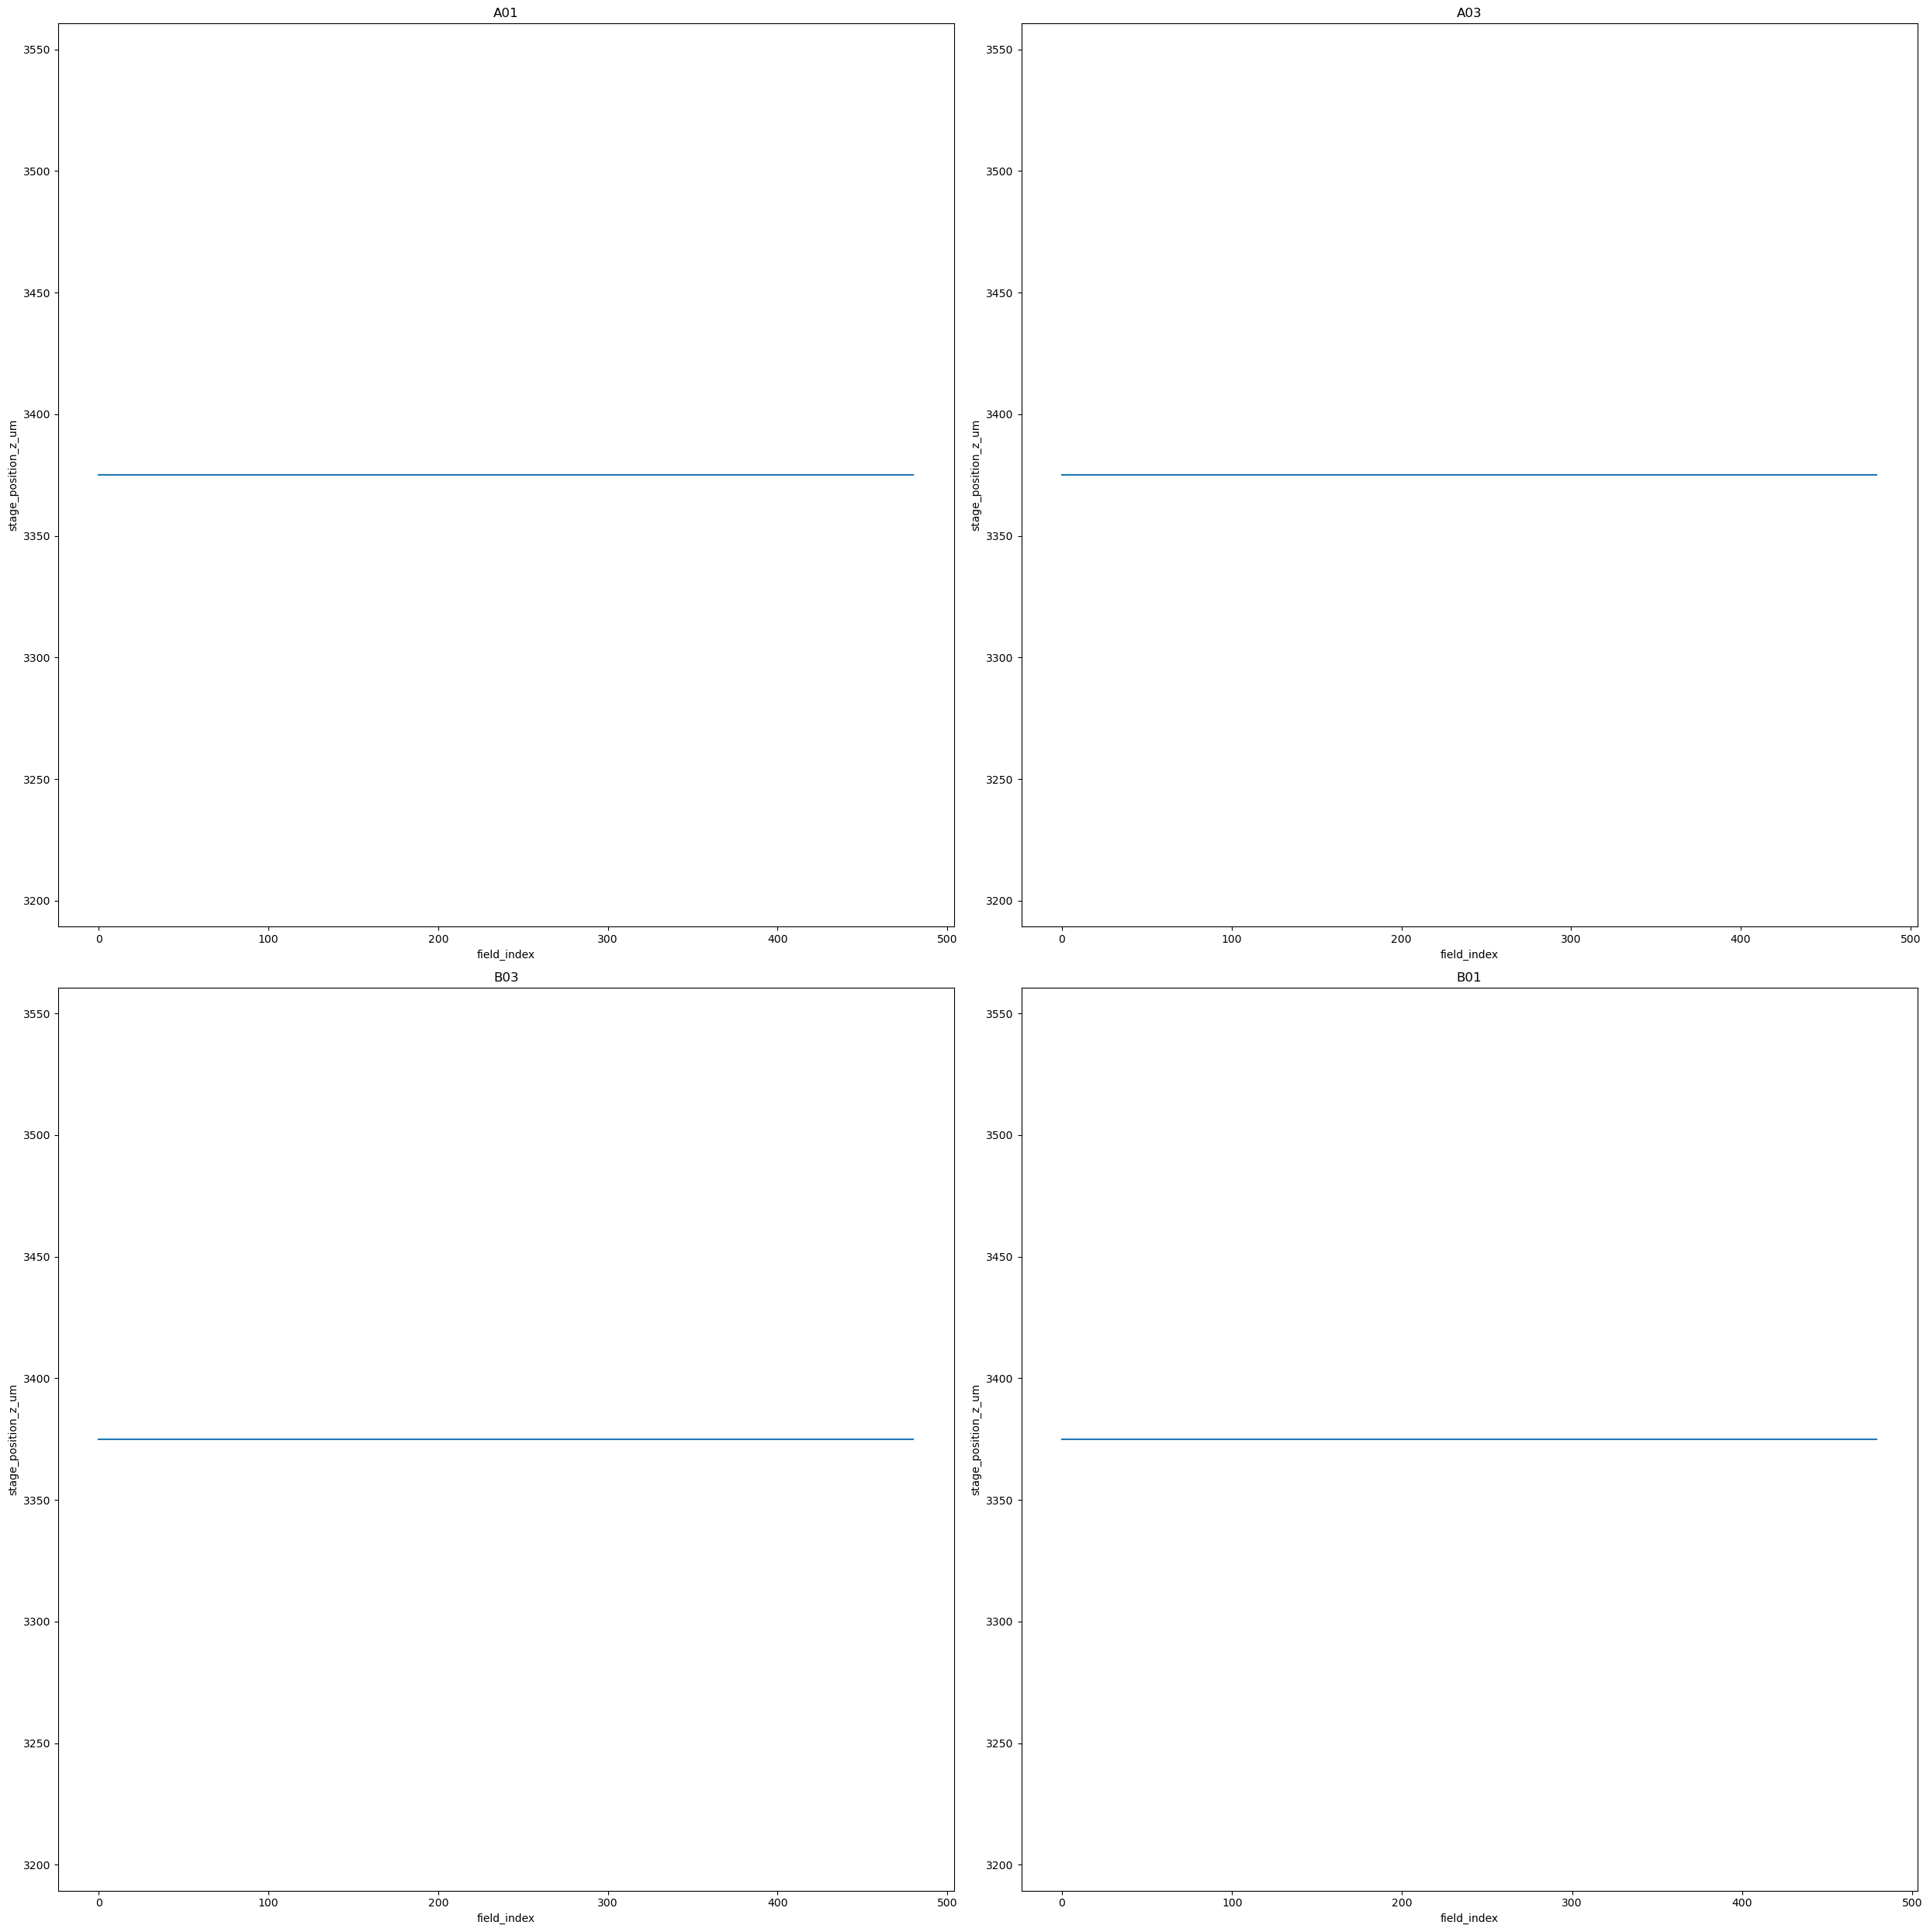

In [24]:
well_locs = PFS_acquisition_df['well_loc'].unique()
cols = 2
rows = len(well_locs)//cols 
fig,ax = plt.subplots(ncols = cols, nrows = rows, figsize=(25,25))
for i, well_loc in enumerate(well_locs):
    row = i//cols
    col = i%cols
    features_subset = PFS_acquisition_df[PFS_acquisition_df['well_loc'] == well_loc]
    sns.lineplot(x = "field_index", y = "stage_position_z_um", data = features_subset, ax = ax[row][col]),
    ax[row][col].set_title(well_loc)   
plt.tight_layout()